In [2]:
import pandas as pd
import numpy as np
np.random.seed(100)

import matplotlib.pyplot as plt
import json
import math

In [77]:
#ANES objects
anes = pd.read_csv('data/anes_timeseries_2020_csv_20220210.csv')

filename = "data/anes_questions.json"
with open(filename, "r") as f:
    questions = json.load(f)

# Question had an option for free text answer, which is not useful for the analysis
# turned into negative value to not take it into account
anes['V201336'].replace(5, -7, inplace=True)

questcode_topic = {"V201336": "abortion policy \n(from 'never permited' to 'always be able')",
              "V202332": "affection of the USA by climate change\n(from 'not at all' to 'a great deal')",
              "V202341x": "gun control background checks \n(from 'favor a great deal' to 'opose a greatl deal')",
              "V202233": "jobs take over by immigration\n(from 'extremely likely' to 'not at all likely')",
              "V202380x": "healthcare spending by the government\n(from should 'increase a great deal' to 'decrease a great deal')"}

C:\Users\agust\AppData\Local\Temp\ipykernel_24020\1696701465.py:2: DtypeWarning: Columns (15,17,18,19,21,22,23,25,26,27,29,30,31,33,34,35,37,38,1508,1509) have mixed types. Specify dtype option on import or set low_memory=False.
  anes = pd.read_csv('data/anes_timeseries_2020_csv_20220210.csv')


In [78]:
#Result objects OpenAI
filename = "outputs/openai_zero_results.json"
with open(filename, "r") as f:
    openai_ans_zero = json.load(f)

filename = "outputs/openai_comments_results.json"
with open(filename, "r") as f:
    openai_ans_comments = json.load(f)

filename = "outputs/openai_comments_strict_results.json"
with open(filename, "r") as f:
    openai_ans_comments_strict = json.load(f)

#openai_ans_zero, openai_ans_comments, openai_ans_comments_strict

#Result objects OS
filename = "outputs/mistral_clean/mistral_zero_ans.json"
with open(filename, "r") as f:
    mistral_ans_zero = json.load(f)

filename = "outputs/mistral_clean/mistral_SE_few_ans.json"
with open(filename, "r") as f:
    mistralSE_ans_comments = json.load(f)

filename = "outputs/mistral_clean/mistral_SE_few_strict.json"
with open(filename, "r") as f:
    mistralSE_ans_comments_strict = json.load(f)


In [91]:
def barplot_results(model, zero, comments, comments_strict, colors):
    num_plots = len(questcode_topic)
    num_cols = 2
    num_rows = math.ceil(num_plots / num_cols)  # Round up to the nearest integer
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

    for idx, (key, values) in enumerate(questcode_topic.items()):
            valid_ans = anes[anes[key] > 0]
            issue = questcode_topic[key]

            # Calculate number of unique answers
            num_answers = len(valid_ans[key].unique())
            counts_zero = zero[key][-1].values() #5 runs and average is in last position
            counts_comments = comments[key][-1].values()
            counts_strict = comments_strict[key][-1].values()

            labels, counts = np.unique(valid_ans[key].to_numpy(), return_counts=True)
            counts_anes = np.around((counts / np.sum(counts)) * 100, 1)

            row = idx // num_cols
            col = idx % num_cols

            #Bars disposition
            num_bars = 4  # Number of bars
            total_width = 0.8  # Total available width for the bars (can be adjusted as needed)
            bar_width = total_width / num_bars 

            axs[row, col].bar(labels - bar_width*1.5, counts_anes, width=bar_width, align='center', color=colors[0])
            axs[row, col].bar(labels - bar_width/2, counts_zero, width=bar_width, align='center', color=colors[1])
            axs[row, col].bar(labels + bar_width/2, counts_comments, width=bar_width, align='center', color=colors[2])
            axs[row, col].bar(labels + bar_width*1.5, counts_strict, width=bar_width, align='center', color=colors[3])

            axs[row, col].set_xticks(labels)

            for label, count in zip(labels, counts_anes):
                axs[row, col].text(label - bar_width*1.5, count, str(round(count)), ha='center', va='bottom')
            for label, count in zip(labels, counts_zero):
                axs[row, col].text(label - bar_width/2, count, str(round(count)), ha='center', va='bottom')
            for label, count in zip(labels, counts_comments):
                axs[row, col].text(label + bar_width/2, count, str(round(count)), ha='center', va='bottom')
            for label, count in zip(labels, counts_strict):
                axs[row, col].text(label + bar_width*1.5, count, str(round(count)), ha='center', va='bottom')

            axs[row, col].set_title('Barplots of {}'.format(issue))
            axs[row, col].set_xlabel('Answer categories')
            axs[row, col].set_ylabel('Percent (%)')

            if idx == 0:
                axs[row, col].figure.legend(['ANES 2020', '{} Instruction'.format(model), 
                                             '{} w/ Comments'.format(model), '{} w/ Comments (strict)'.format(model)],
                                bbox_to_anchor=(0,1), loc='upper left', bbox_transform=axs[row, col].transAxes)

    # Remove empty subplots
    for i in range(num_plots, num_rows*num_cols):
        fig.delaxes(axs.flatten()[i])

    plt.tight_layout()

    plt.savefig('outputs/result_plots/{}_barplot.png'.format(model))
    plt.show()

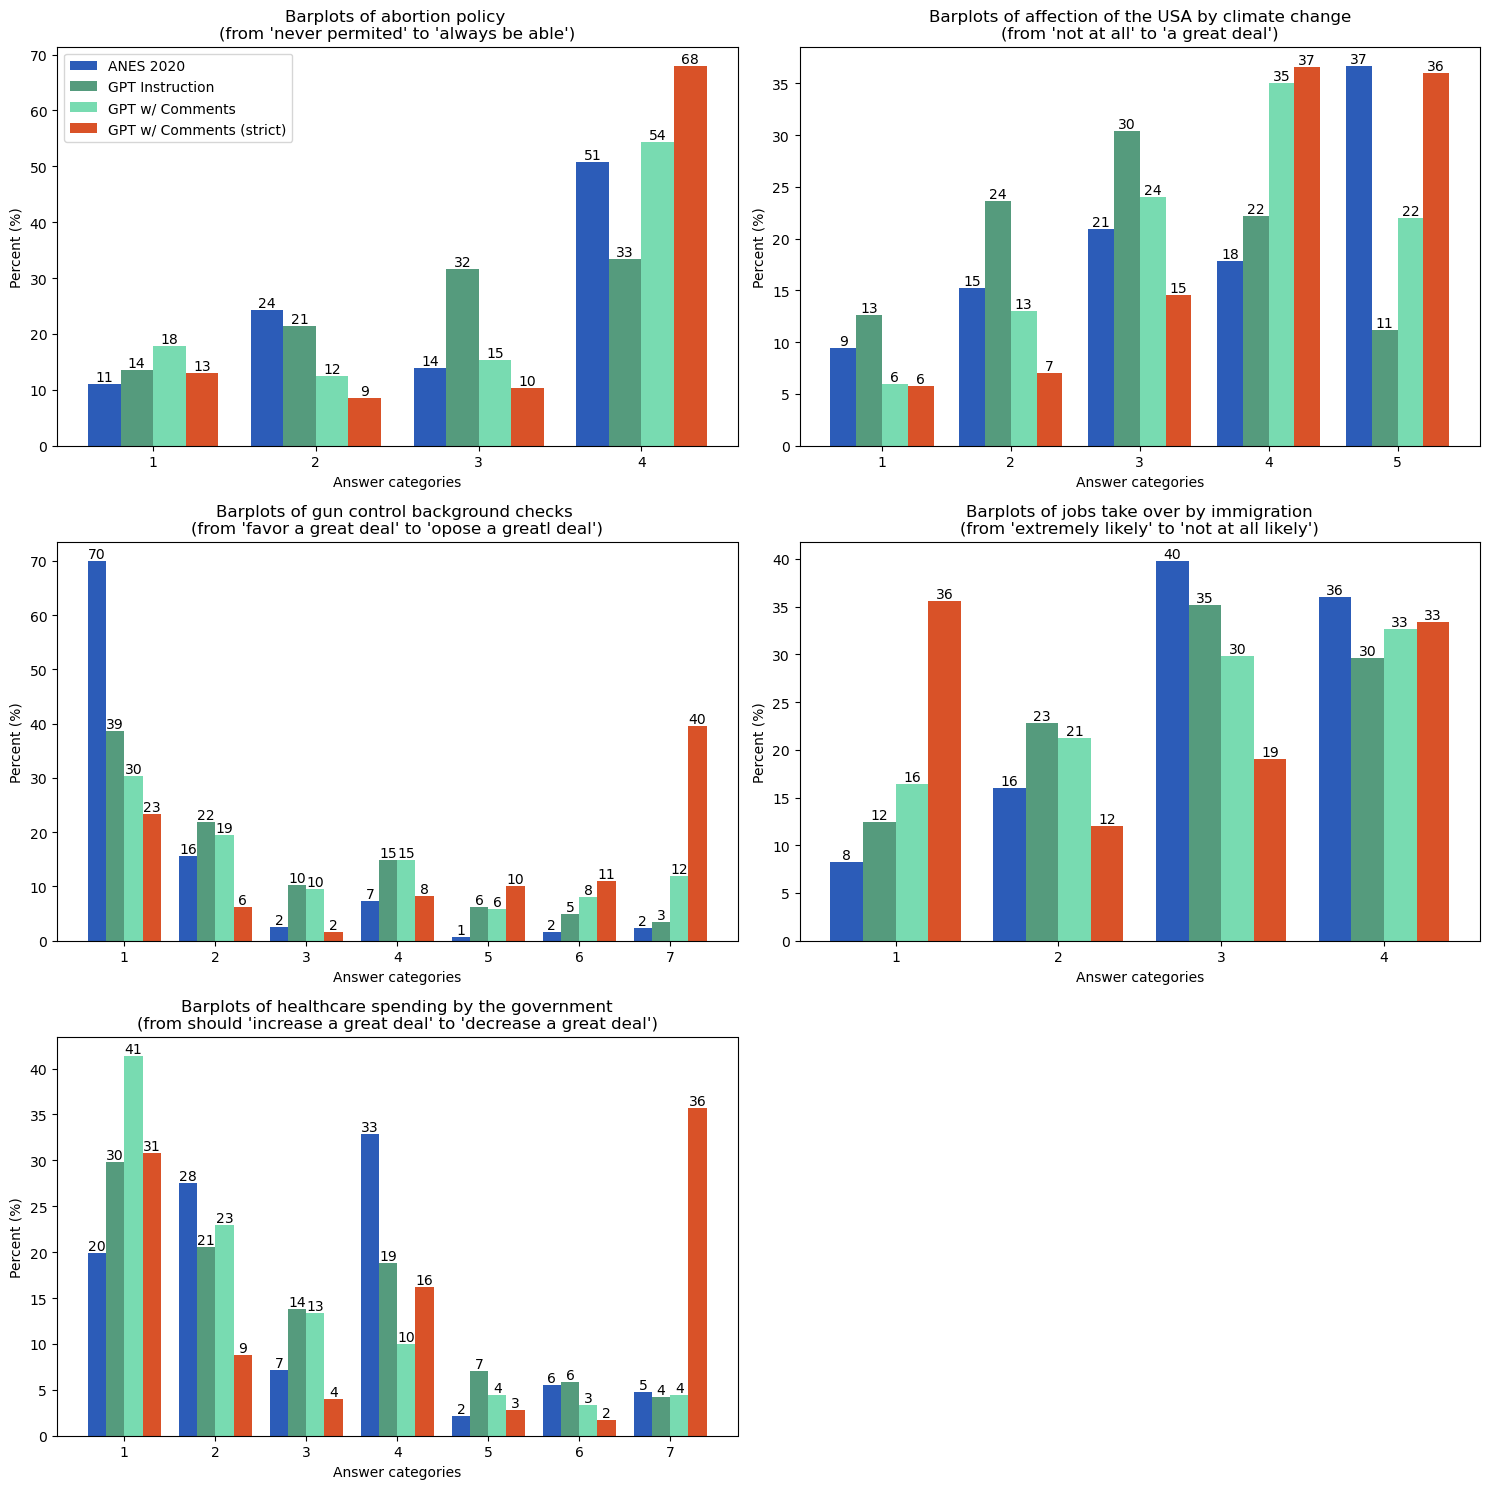

In [92]:
gpt_colors = ["#2c5cb8", "#559B7D", "#78DBB1", "#D95228"]
barplot_results("GPT", openai_ans_zero, openai_ans_comments, openai_ans_comments_strict, gpt_colors)

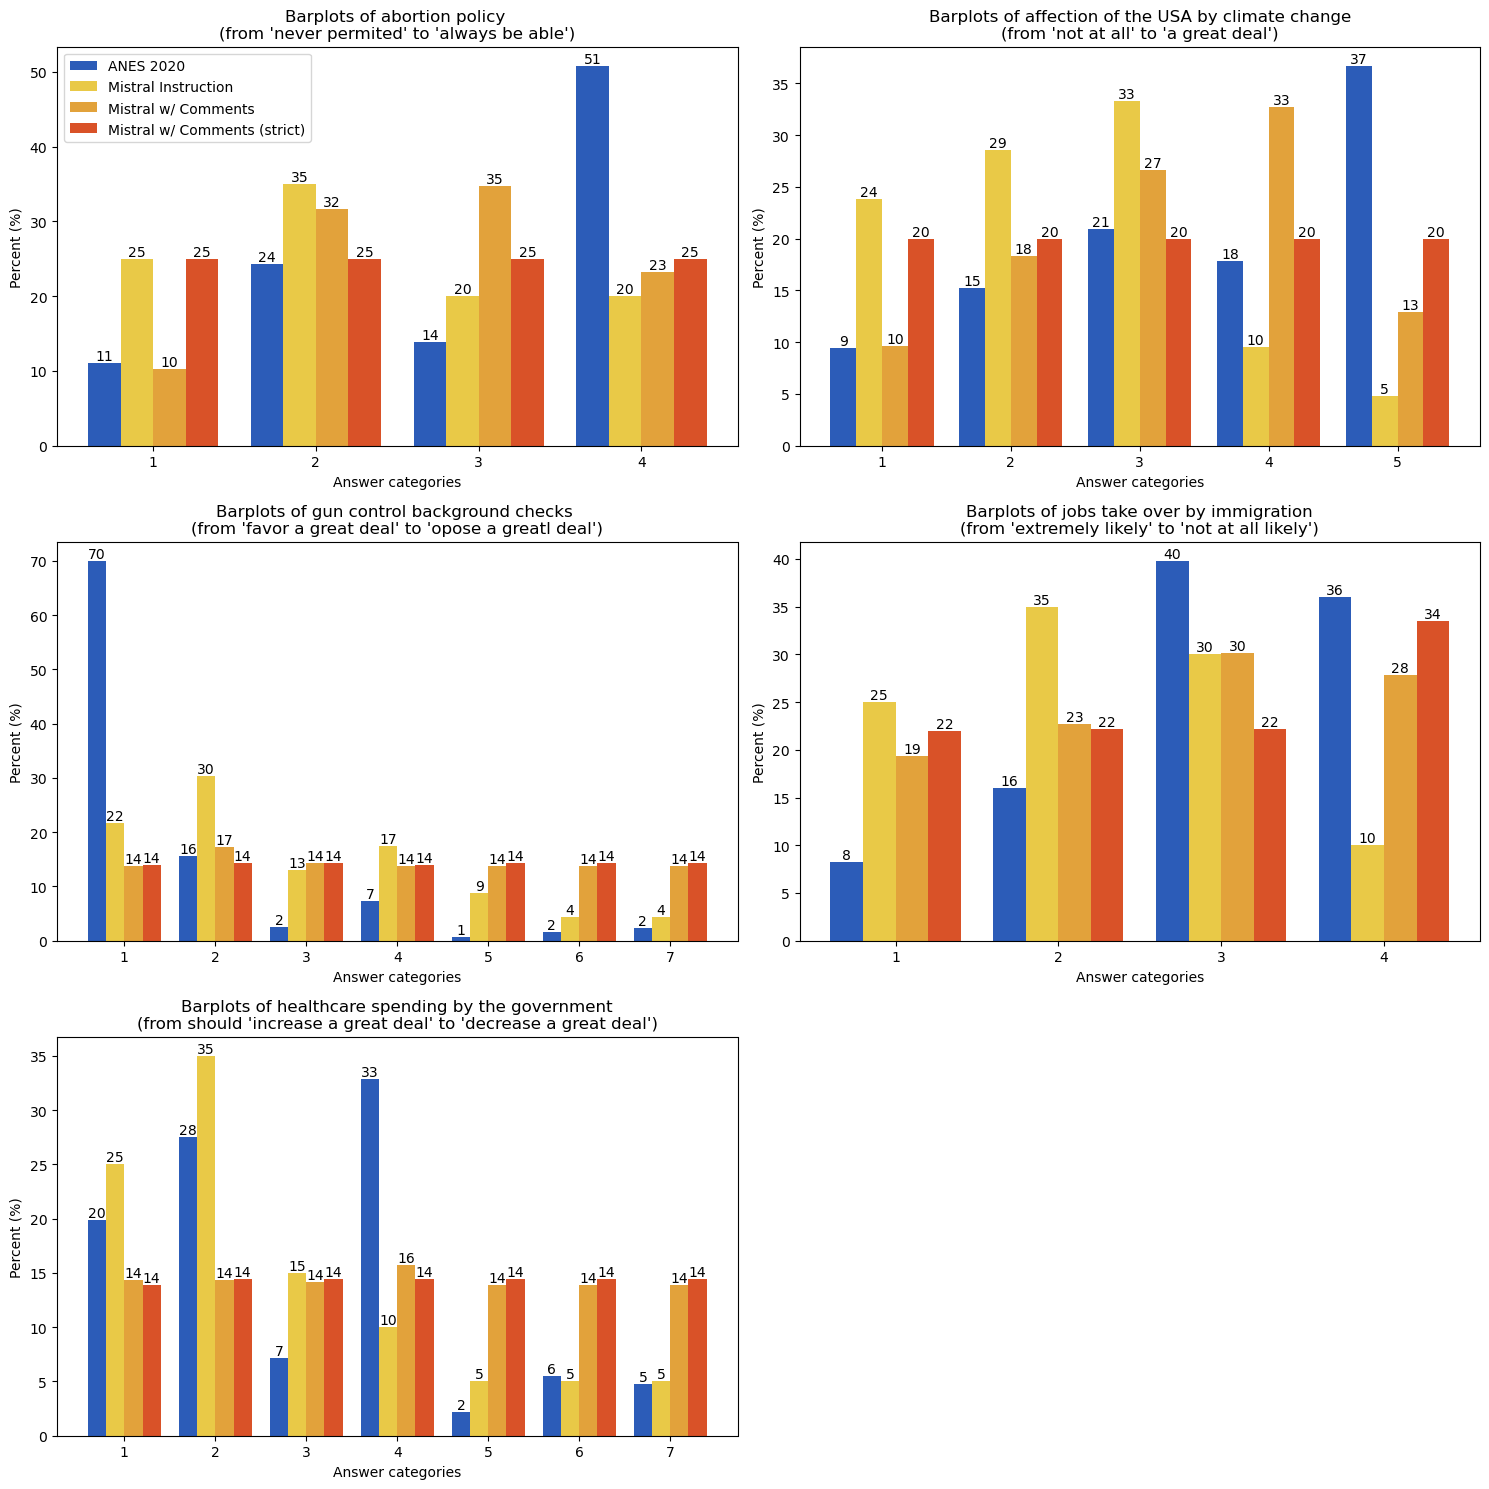

In [93]:
mistral_colors = ["#2c5cb8", "#E9C947", "#E2A23B", "#D95228"]
barplot_results("Mistral", mistral_ans_zero, mistralSE_ans_comments, mistralSE_ans_comments_strict, mistral_colors)

In [70]:
def bootstrap(data, num_iterations=1000):
    bootstrapped_means = []
    bootstrapped_stds = []
    total_samples = np.sum(data)
    for _ in range(num_iterations):
        bootstrap_sample = np.random.choice(np.arange(1, len(data) + 1), size=int(total_samples), replace=True, p=data/np.sum(data))
        bootstrapped_means.append(np.mean(bootstrap_sample))
        bootstrapped_stds.append(np.std(bootstrap_sample))
        
    return bootstrapped_means, bootstrapped_stds

In [94]:
def boxplot_results(model, zero, comments, strictly):
    num_plots = len(questcode_topic)
    num_cols = 2
    num_rows = math.ceil(num_plots / num_cols)  # Round up to the nearest integer
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 5*num_rows))


    mean_comparison_zero = []
    mean_comparison_comments = []
    mean_comparison_strictly = []

    std_comparison_zero = []
    std_comparison_comments = []
    std_comparison_strictly = []

    for idx, (key, issue) in enumerate(questcode_topic.items()):
            
            #Extract Anes data results
            valid_ans = anes[anes[key] > 0]
            #num_answers = len(valid_ans[key].unique())
            labels, counts = np.unique(valid_ans[key].to_numpy(), return_counts=True)
            counts_anes = np.around((counts / np.sum(counts)) * 100, 1)        
            #Extract OpenAI data results
            counts_zero = np.array(list(zero[key][-1].values())) # Ensure one-dimensional array
            counts_comments =  np.array(list(comments[key][-1].values()))
            counts_strictly =  np.array(list(strictly[key][-1].values()))

            # Perform bootstrap for OpenAI and ANES data
            bootstrapped_means_anes, boot_std_anes = bootstrap(counts_anes)
            bootstrapped_means_zero, boot_std_zero = bootstrap(counts_zero)
            bootstrapped_means_comments, boot_std_comments = bootstrap(counts_comments)
            bootstrapped_means_strictly, boot_std_strictly = bootstrap(counts_strictly)

            # Calculate mean and standard deviation
            mean_anes = np.mean(bootstrapped_means_anes)
            mean_zero = np.mean(bootstrapped_means_zero)
            mean_comments = np.mean(bootstrapped_means_comments)
            mean_strictly = np.mean(bootstrapped_means_strictly)

            mean_std_anes = np.mean(boot_std_anes)
            mean_std_zero = np.mean(boot_std_zero)
            mean_std_comments = np.mean(boot_std_comments)
            mean_std_strictly = np.mean(boot_std_strictly)

            #Standard deviation ratio
            if idx != 4: #not order likert but categorical (4th position)
                std_comparison_zero.append(mean_std_zero / mean_std_anes)
                std_comparison_comments.append(mean_std_comments / mean_std_anes)
                std_comparison_strictly.append(mean_std_strictly / mean_std_anes)

                mean_comparison_zero.append(mean_anes-mean_zero)
                mean_comparison_comments.append(mean_anes-mean_comments)
                mean_comparison_strictly.append(mean_anes-mean_strictly)
            
            row = idx // num_cols
            col = idx % num_cols

            # Plot boxplots with error bars for OpenAI and ANES
            axs[row, col].boxplot([[mean_strictly],[mean_comments], [mean_zero], [mean_anes]], vert=False, 
                                  positions=[0, 1, 2, 3], widths=0.6, patch_artist=True)
            axs[row, col].errorbar([mean_strictly, mean_comments, mean_zero, mean_anes], [0, 1, 2, 3], 
                                   xerr=[mean_std_strictly, mean_std_comments, mean_std_zero, mean_std_anes], 
                                   fmt='o', color='black', capsize=5)
            axs[row, col].set_yticks([0, 1, 2, 3])
            axs[row, col].set_yticklabels(['{} w/ \ncomments (strict)'.format(model),'{} w/\ncomments'.format(model), 
                                           '{} Instruction'.format(model), 'ANES 2020'], fontsize=9)
            axs[row, col].set_xticks(np.arange(1, len(counts_anes) + 1))
            axs[row, col].set_title('Boxplot of bootstraped results for\n{}'.format(issue), fontsize=11)

    # Remove empty subplots
    for i in range(num_plots, num_rows*num_cols):
        fig.delaxes(axs.flatten()[i])

    plt.tight_layout()

    plt.savefig('outputs/result_plots/{}_boxplot.png'.format(model))
    plt.show()

    average_ratio_zero = np.mean(std_comparison_zero)
    average_ratio_comments = np.mean(std_comparison_comments)
    average_ratio_strictly = np.mean(std_comparison_strictly)
    avg_meandiff_zero = np.mean(mean_comparison_zero)
    avg_meandiff_comments = np.mean(mean_std_comments)
    avg_meandiff_strictly = np.mean(mean_std_strictly)


    print("Average ratio of {}'s std dev to ANES's:".format(model), average_ratio_zero,", Mean difference gap:", avg_meandiff_zero)
    print("Average ratio of {}'s std dev with comments to ANES's:".format(model), average_ratio_comments,", Mean difference gap:", avg_meandiff_comments)
    print("Average ratio of {}'s std dev with comments (strict) to ANES's:".format(model), average_ratio_strictly,", Mean difference gap:", avg_meandiff_strictly)

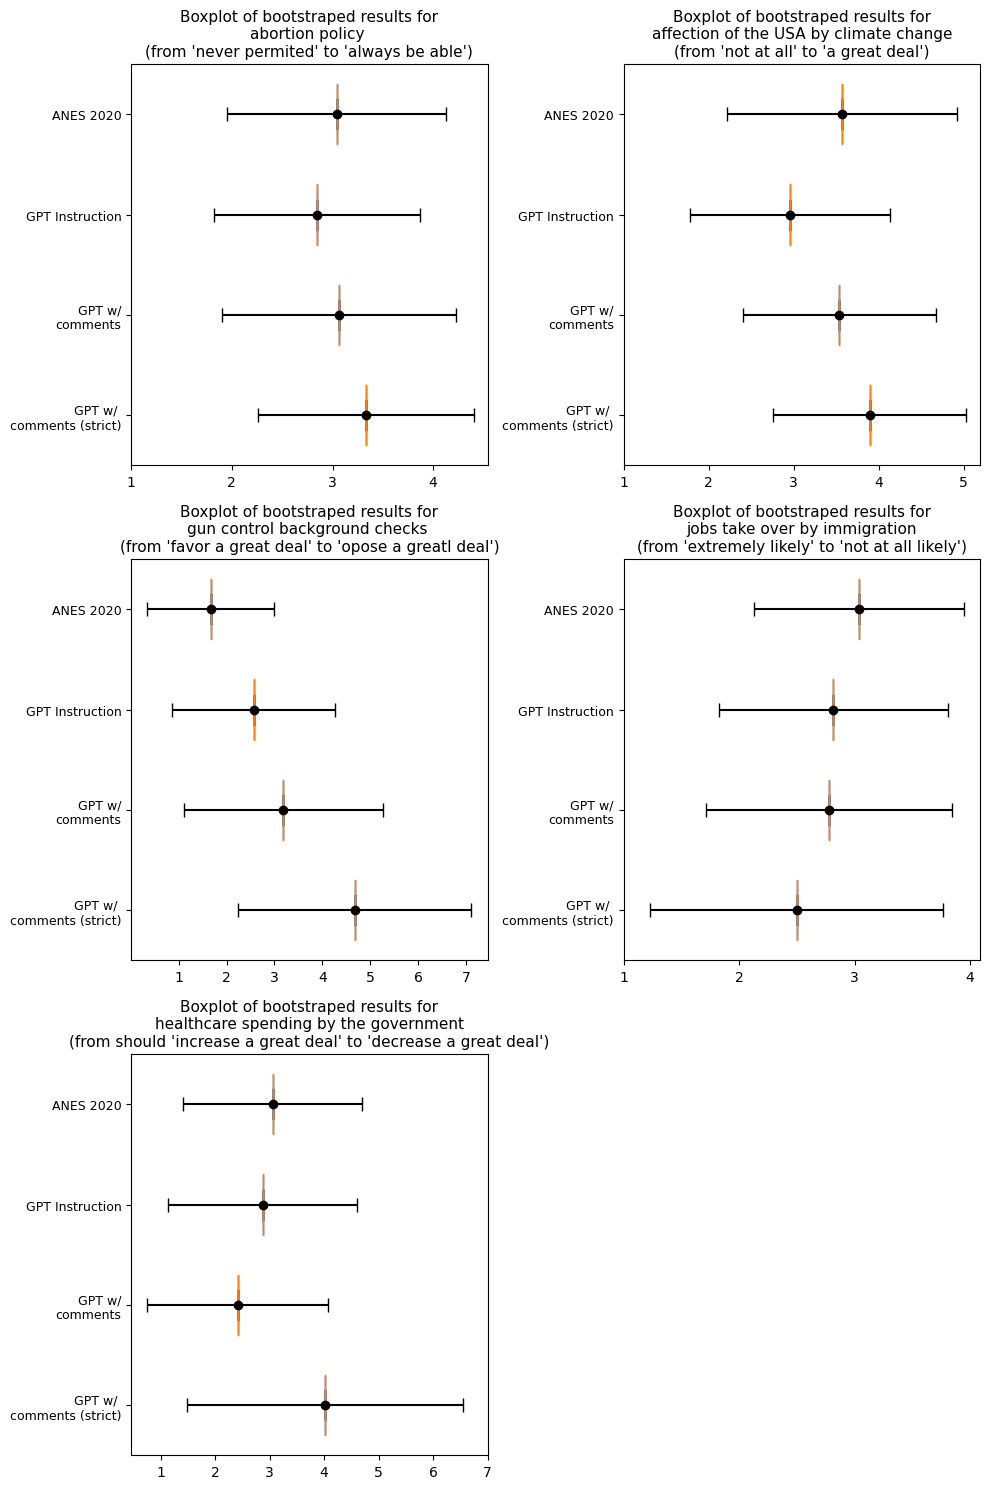

Average ratio of GPT's std dev to ANES's: 1.0490084620947655 , Mean difference gap: 0.03250330808080781
Average ratio of GPT's std dev with comments to ANES's: 1.1652215427444492 , Mean difference gap: 1.6656320063673284
Average ratio of GPT's std dev with comments (strict) to ANES's: 1.2684196363403955 , Mean difference gap: 2.528596757336538


In [95]:
boxplot_results("GPT", openai_ans_zero, openai_ans_comments, openai_ans_comments_strict)

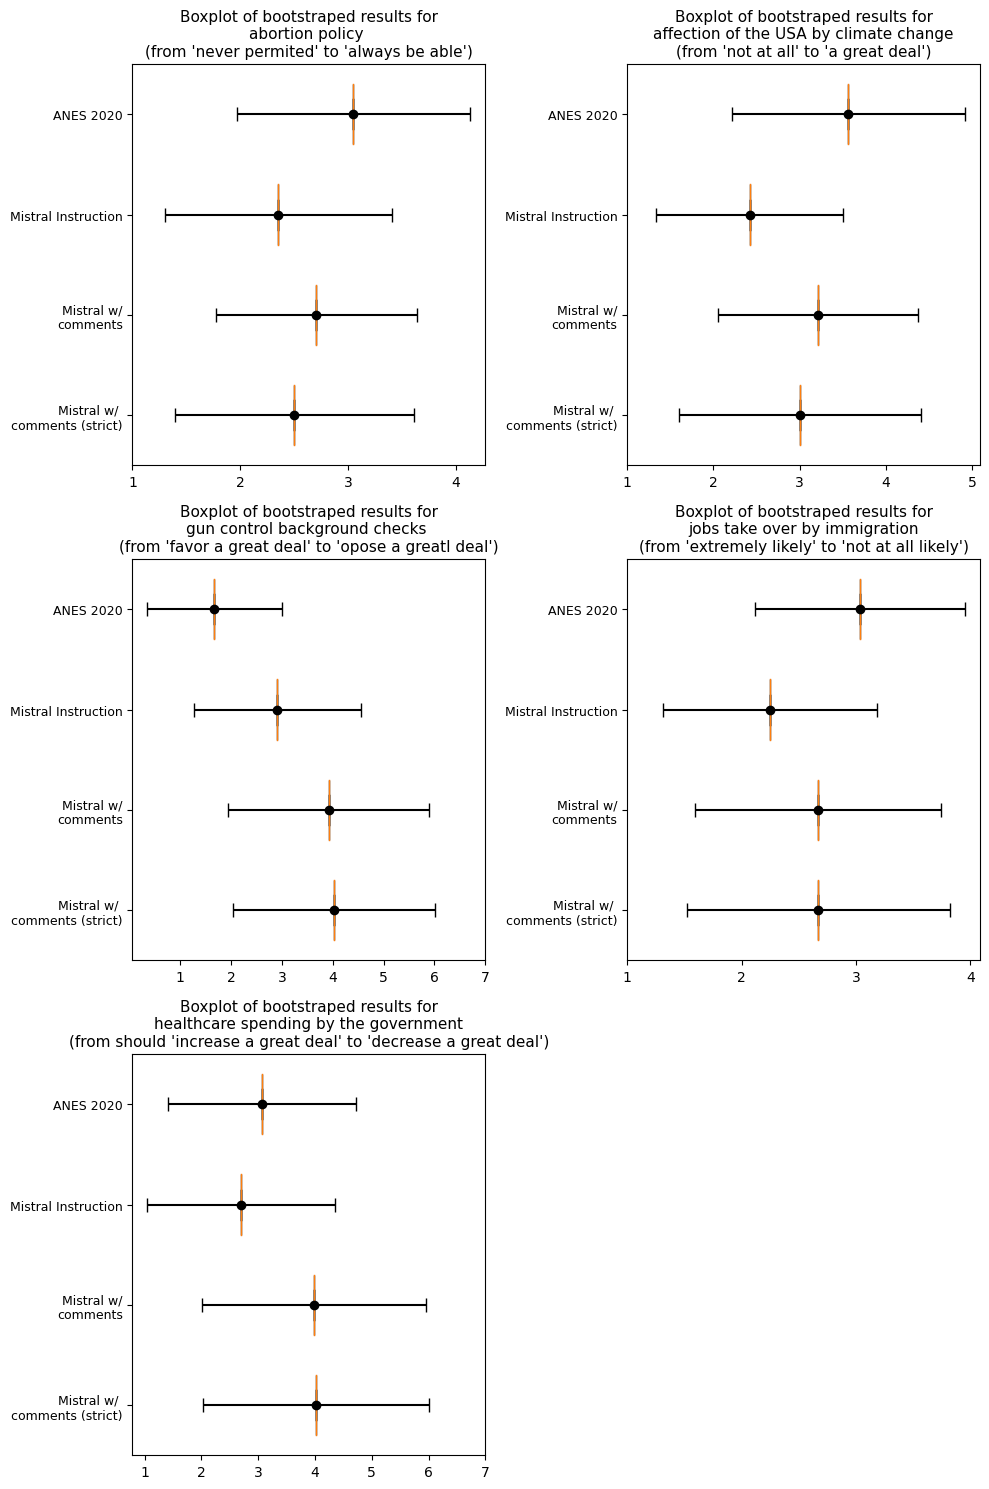

Average ratio of Mistral's std dev to ANES's: 1.009793482894362 , Mean difference gap: 0.34542840909090883
Average ratio of Mistral's std dev with comments to ANES's: 1.0968911509519501 , Mean difference gap: 1.97382331579542
Average ratio of Mistral's std dev with comments (strict) to ANES's: 1.205205753063242 , Mean difference gap: 1.9818036321426467


In [96]:
boxplot_results("Mistral", mistral_ans_zero, mistralSE_ans_comments, mistralSE_ans_comments_strict)

In [57]:
mean_var = {}

for key, value in questions.items():
    # Only include valid answers
    valid = anes[anes[key] > 0]
    # frequencies = valid[key].value_counts()
    column_mean = valid[key].mean()
    column_var = valid[key].var()
    num_respondents = len(valid[key])
    mean_var[key] = [column_mean, column_var, num_respondents]
    
mean_var

{'V201336': [3.0456962025316456, 1.189581424343106, 7900],
 'V201342x': [4.689327485380117, 4.338709039566053, 8208],
 'V202332': [3.5717382468500203, 1.8473258263269425, 7381],
 'V202333': [3.340511986997156, 1.825786082997807, 7383],
 'V202337': [1.89735593220339, 0.9236911365172453, 7375],
 'V202341x': [1.6703668607012319, 1.812394165422136, 7387],
 'V202344x': [3.207424468229237, 5.664150831861712, 7381],
 'V202232': [2.9915646258503403, 1.2937103016468015, 7350],
 'V202233': [3.0364054675869534, 0.8464005047669663, 7389],
 'V202236x': [3.072867378667027, 3.1129968202944625, 7397],
 'V202380x': [3.0557224801966676, 2.7443334555495578, 7322]}

In [86]:
from scipy.stats import mannwhitneyu

def u_mannwhitney(ans_object):

    # Number of tests
    num_tests = len(ans_object.keys())

    # Dictionary to store results
    results_dict = {}

    # Loop over each key in openai_ans_zero
    for key in ans_object:
        # Get the values from openai_ans_zero for the current key
        openai_values = np.array(list(ans_object[key][-1].values()))
        
        # Get the percentages from valid_ans for the current key
        valid_ans = anes[anes[key] > 0]
        labels, counts = np.unique(valid_ans[key].to_numpy(), return_counts=True)
        anes_values = np.around((counts / np.sum(counts)) * 100, 1)

        # Perform Mann-Whitney U test
        u_statistic, p_value = mannwhitneyu(openai_values, anes_values, alternative='two-sided')

        if p_value < 0.05:
            print(f"Significant difference for {questcode_topic[key]} with p-value {p_value}")
        
        # Correct p-value for multiple tests using Bonferroni correction
        corrected_p_value = p_value * num_tests
        
        
        # Calculate Cliff's delta
        delta = (np.sum(np.sign(np.subtract.outer(openai_values, anes_values))) / (len(openai_values) * len(anes_values)))

        # Store results in dictionary
        results_dict[key] = {
            'u_statistic': u_statistic,
            'p_value': p_value,
            'corrected_p_value': corrected_p_value,
            'delta': delta
        }

    return	results_dict

In [87]:
stat_tests_zero_gpt = u_mannwhitney(openai_ans_zero)
stat_tests_comments_gpt = u_mannwhitney(openai_ans_comments)
stat_tests_strict_gpt = u_mannwhitney(openai_ans_comments_strict)

In [88]:
stat_tests_strict_mistral = u_mannwhitney(mistral_ans_zero)
stat_tests_strict_mistral = u_mannwhitney(mistralSE_ans_comments)
stat_tests_strict_mistral = u_mannwhitney(mistralSE_ans_comments_strict)